## Importación de Bibliotecas

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torchvision.models as models
import torchvision.transforms as transforms

from xgboost import XGBClassifier, XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report

import pickle

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import randint

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [21]:
dataset = pd.read_csv('data/data.csv')

## Codificar Variables Categóricas

In [22]:
numeric_features = ['extent']
categorical_features = ['growth_stage', 'damage', 'season']

In [23]:
transformers_encoder_onehot = [
    ('encoder', OneHotEncoder(), categorical_features)
]
column_transformer = ColumnTransformer(transformers_encoder_onehot, remainder='passthrough')

In [24]:
dataset_encoded = column_transformer.fit_transform(dataset)
dataset = pd.DataFrame(dataset_encoded, columns=column_transformer.get_feature_names_out())

In [25]:
new_column_names = [col.replace('encoder__', '').replace('remainder__', '') for col in column_transformer.get_feature_names_out()]
dataset.columns = new_column_names

In [26]:
dataset = dataset.drop(columns=['ID'])

In [27]:
dataset.head()

,growth_stage_F,growth_stage_M,growth_stage_S,growth_stage_V,damage_DR,damage_DS,damage_FD,damage_G,damage_ND,damage_PS,damage_WD,damage_WN,season_LR2020,season_LR2021,season_SR2020,season_SR2021,filename,extent
0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,L427F01330C01S03961Rp02052.jpg,0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L1083F00930C39S12674Ip.jpg,0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,24_initial_1_1463_1463.JPG,0
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,L341F00167C01S00324Rp14178.jpg,60
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,L1084F02394C39S13931Ip.jpg,0


## CNN 

In [28]:
image_size = 224
data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],  
        std=[0.229, 0.224, 0.225]     
    ),
])

In [29]:
resnet50 = models.resnet50(pretrained=True)
resnet50 = torch.nn.Sequential(*list(resnet50.children())[:-1])
resnet50 = resnet50.to(device)
resnet50.eval()

c:\Users\TheKi\OneDrive - UVG\Semestre VIII\data-science\EyesOnTheGround\env3.9\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\TheKi\OneDrive - UVG\Semestre VIII\data-science\EyesOnTheGround\env3.9\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [30]:
def extract_image_features(image_paths):
    features = []
    with torch.no_grad():
        for path in image_paths:
            # Load and preprocess the image
            image = Image.open('data/train/' + path).convert('RGB')
            image = data_transforms(image).unsqueeze(0).to(device)
            # Extract features
            feature = resnet50(image)
            feature = feature.cpu().numpy().flatten()
            features.append(feature)
    return np.array(features)

In [31]:
image_filenames = dataset['filename'].values
image_features = extract_image_features(image_filenames)
print(f"Extracted image features shape: {image_features.shape}")

Extracted image features shape: (26068, 2048)


## Merge de features

In [32]:
encoded_features = dataset.drop(columns=['extent', 'filename']).values

X = np.hstack((image_features, encoded_features))

y = dataset['extent'].values.astype(float)

print(f"Combined feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

Combined feature matrix shape: (26068, 2064)
Target variable shape: (26068,)


## Clasificación de plantas con enfermedad

In [33]:
with open('models/xgb_classifier.pkl', 'rb') as file:
    xgb_classifier = pickle.load(file)

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
# Crear las etiquetas binarias para los datos de entrenamiento y prueba
y_train_binary = (y_train > 0).astype(int)
y_test_binary = (y_test > 0).astype(int)

In [36]:
xgb_classifier = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
xgb_classifier.fit(X_train, y_train_binary)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [37]:
y_pred_binary = xgb_classifier.predict(X_test)

print(f"Accuracy: {accuracy_score(y_test_binary, y_pred_binary)}")
print(classification_report(y_test_binary, y_pred_binary))

Accuracy: 0.9994246260069045
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4275
           1       1.00      1.00      1.00       939

    accuracy                           1.00      5214
   macro avg       1.00      1.00      1.00      5214
weighted avg       1.00      1.00      1.00      5214



In [38]:
X_train_reg = X_train[y_train_binary == 1]
y_train_reg = y_train[y_train_binary == 1]

X_test_reg = X_test[y_pred_binary == 1]
y_test_reg = y_test[y_pred_binary == 1] 

In [39]:
with open('models/xgb_classifier.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)

## Regresión para plantas enfermas

In [40]:
# Entrenar el modelo con hiperparámetros predeterminados
rf_regressor = RandomForestRegressor(random_state=42)
rf_regressor.fit(X_train_reg, y_train_reg)

# Evaluar el modelo
y_pred_reg = rf_regressor.predict(X_test_reg)

# Calcular métricas de desempeño
rmse_test = mean_squared_error(y_test_reg, y_pred_reg, squared=False)
r2_test = rf_regressor.score(X_test_reg, y_test_reg)
print(f"RMSE en conjunto de prueba: {rmse_test}")
print(f"R^2 en conjunto de prueba: {r2_test}")

RMSE en conjunto de prueba: 19.001704303939487
R^2 en conjunto de prueba: 0.40295593646281114


c:\Users\TheKi\OneDrive - UVG\Semestre VIII\data-science\EyesOnTheGround\env3.9\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [41]:
for actual, predicted in zip(y_test_reg, y_pred_reg):
    print(f"Actual: {actual}, Predicho: {predicted}")

Actual: 30.0, Predicho: 28.0
Actual: 10.0, Predicho: 19.2
Actual: 40.0, Predicho: 60.8
Actual: 80.0, Predicho: 33.1
Actual: 30.0, Predicho: 35.2
Actual: 50.0, Predicho: 44.9
Actual: 40.0, Predicho: 27.4
Actual: 20.0, Predicho: 22.1
Actual: 90.0, Predicho: 53.4
Actual: 40.0, Predicho: 49.1
Actual: 30.0, Predicho: 29.2
Actual: 70.0, Predicho: 40.3
Actual: 80.0, Predicho: 75.3
Actual: 80.0, Predicho: 58.2
Actual: 30.0, Predicho: 27.1
Actual: 60.0, Predicho: 46.4
Actual: 40.0, Predicho: 34.3
Actual: 30.0, Predicho: 40.3
Actual: 50.0, Predicho: 46.8
Actual: 50.0, Predicho: 35.7
Actual: 60.0, Predicho: 61.2
Actual: 80.0, Predicho: 77.9
Actual: 80.0, Predicho: 58.9
Actual: 70.0, Predicho: 42.2
Actual: 40.0, Predicho: 27.9
Actual: 10.0, Predicho: 21.6
Actual: 30.0, Predicho: 31.5
Actual: 10.0, Predicho: 29.9
Actual: 100.0, Predicho: 49.7
Actual: 30.0, Predicho: 66.2
Actual: 40.0, Predicho: 43.3
Actual: 90.0, Predicho: 66.7
Actual: 20.0, Predicho: 31.9
Actual: 30.0, Predicho: 21.3
Actual: 40.0,

## Guardar modelos

In [42]:
# Guardar el clasificador entrenado
with open('models/xgb_classifier.pkl', 'wb') as file:
    pickle.dump(xgb_classifier, file)

# Guardar el regresor entrenado
with open('models/rf_regressor.pkl', 'wb') as file:
    pickle.dump(rf_regressor, file)
    
# Guardar el one-hot encoder
with open('models/one_hot_encoder.pkl', 'wb') as file:
    pickle.dump(column_transformer, file)

## Gráficas

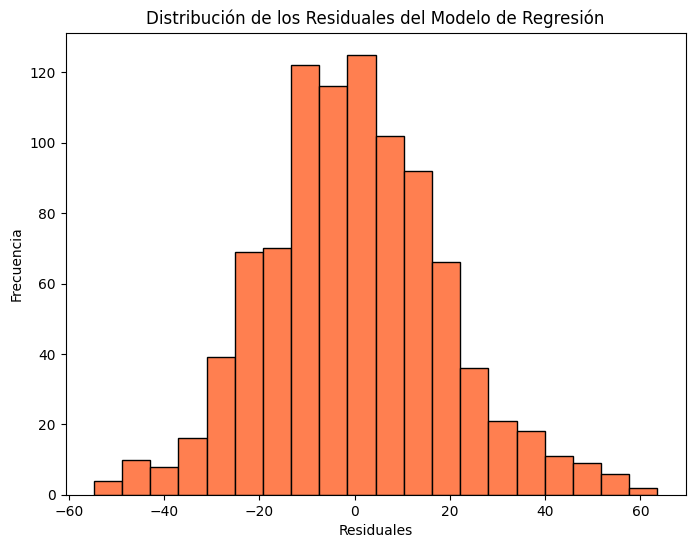

In [43]:
residuals = y_test_reg - y_pred_reg

plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=20, color='coral', edgecolor='black')
plt.xlabel('Residuales')
plt.ylabel('Frecuencia')
plt.title('Distribución de los Residuales del Modelo de Regresión')
plt.show()


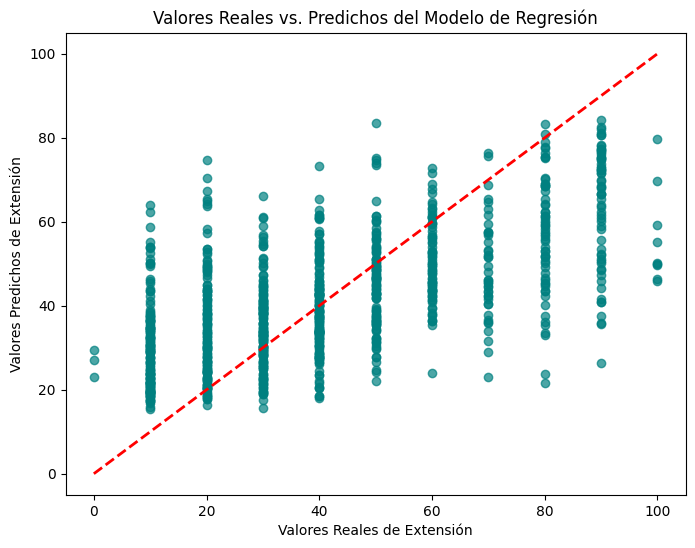

In [44]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.7, color='teal')
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'r--', lw=2)
plt.xlabel('Valores Reales de Extensión')
plt.ylabel('Valores Predichos de Extensión')
plt.title('Valores Reales vs. Predichos del Modelo de Regresión')
plt.show()

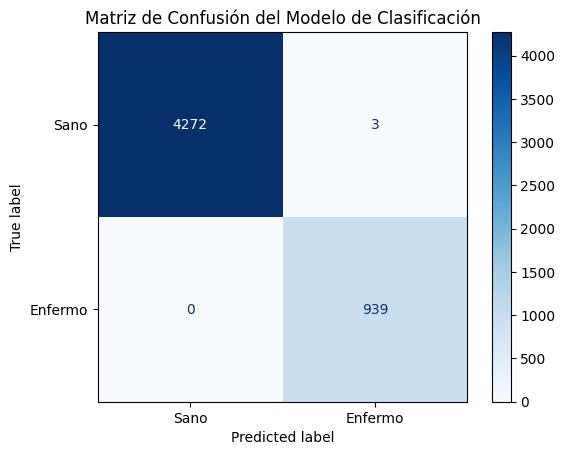

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test_binary, y_pred_binary)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Sano', 'Enfermo'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Matriz de Confusión del Modelo de Clasificación')
plt.show()